In [1]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

In [3]:
# Load in metadata
meta = pd.read_json(f"{DATA_PATH}/Zalando_Germany_Dataset/dresses/metadata/dresses_metadata.json").T.rename_axis('sku').reset_index()
# Rename category "Cocktail dress / Party dress" to "Cocktail dress" to avoid problems in path definitions
meta['category'] = meta['category'].replace('Cocktail dress / Party dress', 'Cocktail dress')
# Rename "3/4 length" to "34 length" to avoid problems in path definitions
meta['sleeve_length'] = meta['sleeve_length'].replace('3/4 length', '34 length')

### Helper Functions

In [4]:
def tensor2im(var):
    var = var.cpu().detach().transpose(0, 2).transpose(0, 1).numpy()
    var = ((var + 1) / 2)
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

In [5]:
def setup_generator():
    os.chdir(f"{ROOT_PATH}/stylegan2-ada-pytorch")
    # Load model architecture
    experiment_path = f"{DATA_PATH}/Models/Stylegan2_Ada/Experiments/00005-stylegan2_ada_images-mirror-auto2-kimg5000-resumeffhq512/"
    model_name = "network-snapshot-001200.pkl"
    model_path = experiment_path + model_name
    with open(model_path, 'rb') as f:
        architecture = pickle.load(f)
        G = architecture['G_ema']
        D = architecture['D']
    os.chdir(current_wd)
    return G

G = setup_generator()

In [6]:
def generate_from_latent(latent):
    img = G.synthesis(latent, force_fp32=True, noise_mode = 'const')
    img = tensor2im(img.squeeze(0))
    return img

In [7]:
os.chdir(f"{ROOT_PATH}/2_Inversion/hyperstyle/")
from hyperstyle_utils import *
os.chdir(current_wd)
G_hyp = load_hyperstyle()

Using cuda as device
Loading HyperStyle from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/hyperstyle/00005_snapshot_1200_restyle_77000/resume/checkpoints/best_model.pt
Loading pretrained W encoder...
Loading ReStyle e4e from checkpoint: /pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync/Models/restyle/00005_snapshot_1200/checkpoints/best_model.pt
Model successfully loaded!


In [8]:
def get_interpolations(latent_code, start_distance, end_distance, steps, boundaries_base_dir):
    linspace = np.linspace(start_distance, end_distance, steps)

    # Repeat Latent for num_steps
    latent_code = latent_code.repeat(steps, 1, 1)

    boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")
    boundary = torch.tensor(boundary, device = 'cuda')
    for i in range(steps):
        latent_code[i, :, :] = latent_code[i, :, :] + linspace[i] * boundary
    
    return latent_code

### Manipulations

In [9]:
sku = "02R21C00O-Q11"
hyperstyle_latents = np.load(f'{DATA_PATH}/Generated_Images/hyperstyle/latents.npy', allow_pickle=True).item()
latent_hyperstyle, weight_delta = load_generator_inputs(sku, hyperstyle_latents)

gen, img = generate_hyperstyle(latent_hyperstyle, weight_delta, G_hyp, return_image=True)

In [10]:
def run_example(attribute, att1, att2, steps=5, distance=40):

    try:
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundary = np.load(f"{boundaries_base_dir}boundary_dim.npy")

    except:
        att1, att2 = att2, att1
        input_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Inputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"
        boundaries_base_dir = f"{DATA_PATH}/Models/InterfaceGAN/Outputs/e4e_00005_concatenated/{attribute}/{att1}_{att2}/"

    # Load in Metadata
    df = pd.read_csv(f"{input_base_dir}metadata.csv")
    training_stats = pd.read_csv(f"{boundaries_base_dir}summary_stats.csv")


    # Sample one latent
    sample = df.sample(1)
    sku = sample.sku.item()

    latent_hyperstyle, weight_delta = load_generator_inputs(sku, hyperstyle_latents)
    latent_hyperstyle =latent_hyperstyle.flatten()

    # Generate Interpolations
    if sample.label.item() == 0: 
        start_distance, end_distance = 0, distance
    elif sample.label.item() == 1: 
        start_distance, end_distance = -distance,  0

    # Generate interpolations and images
    interpolations = get_interpolations(latent_hyperstyle, start_distance, end_distance, steps, boundaries_base_dir)

    imgs = []
    for i in range(steps):
        gen, img = generate_hyperstyle(interpolations[i, :, :].squeeze(0).reshape(16,512), weight_delta, G_hyp, return_image=True)
        imgs.append(img)


    ######### Plot Everything
    fig, ax = plt.subplots(1, 2+len(imgs), figsize = (20,8))

    # Orig Image:
    orig = Image.open(f'{DATA_PATH}/Zalando_Germany_Dataset/dresses/images/square_images/{sku}.jpg')
    ax[0].imshow(orig)

    # Inversion
    if start_distance == 0:
        inv = imgs[0]
    else: 
        inv = imgs[-1]

    ax[1].imshow(inv)

    # Manipulations
    for i in range(len(imgs)):
        ax[i+2].imshow(imgs[i])

    # Set titles
    titles = ['Original', 'Inversion'] + [str(elem) for elem in np.linspace(start_distance, end_distance, steps)]
    for i in range(len(titles)):
        ax[i].set_title(titles[i])

    # Remove Exis
    for axs in ax.flatten():
        axs.axis('off')

    # Set figure title
    fig.suptitle(f"SKU: {sample.sku.item()}\nClass:{sample[attribute].item()} \n{att1} <-> {att2}\nBoundary Acc: {np.round(training_stats.acc.item(), 2)}")
    fig.tight_layout()
    plt.show()


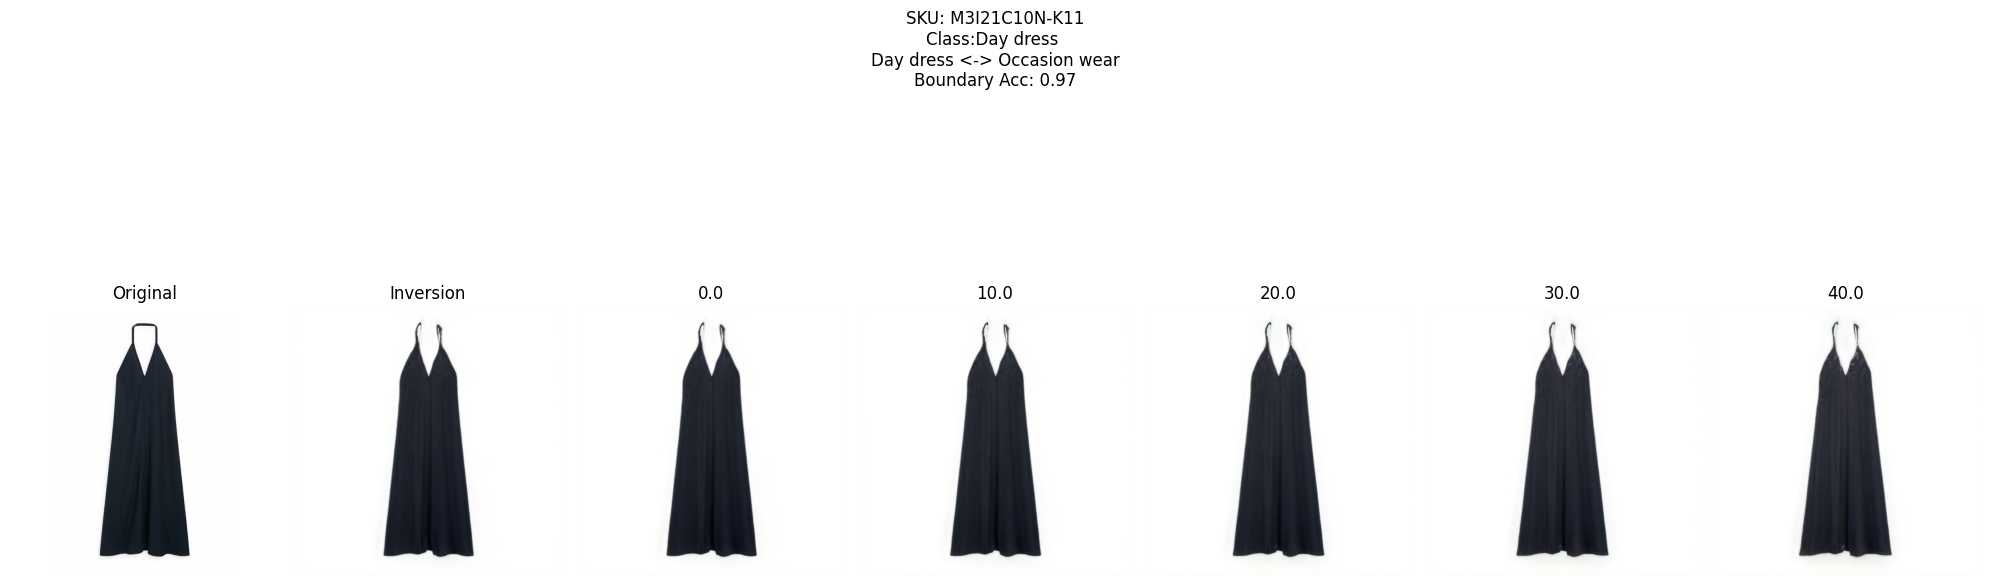

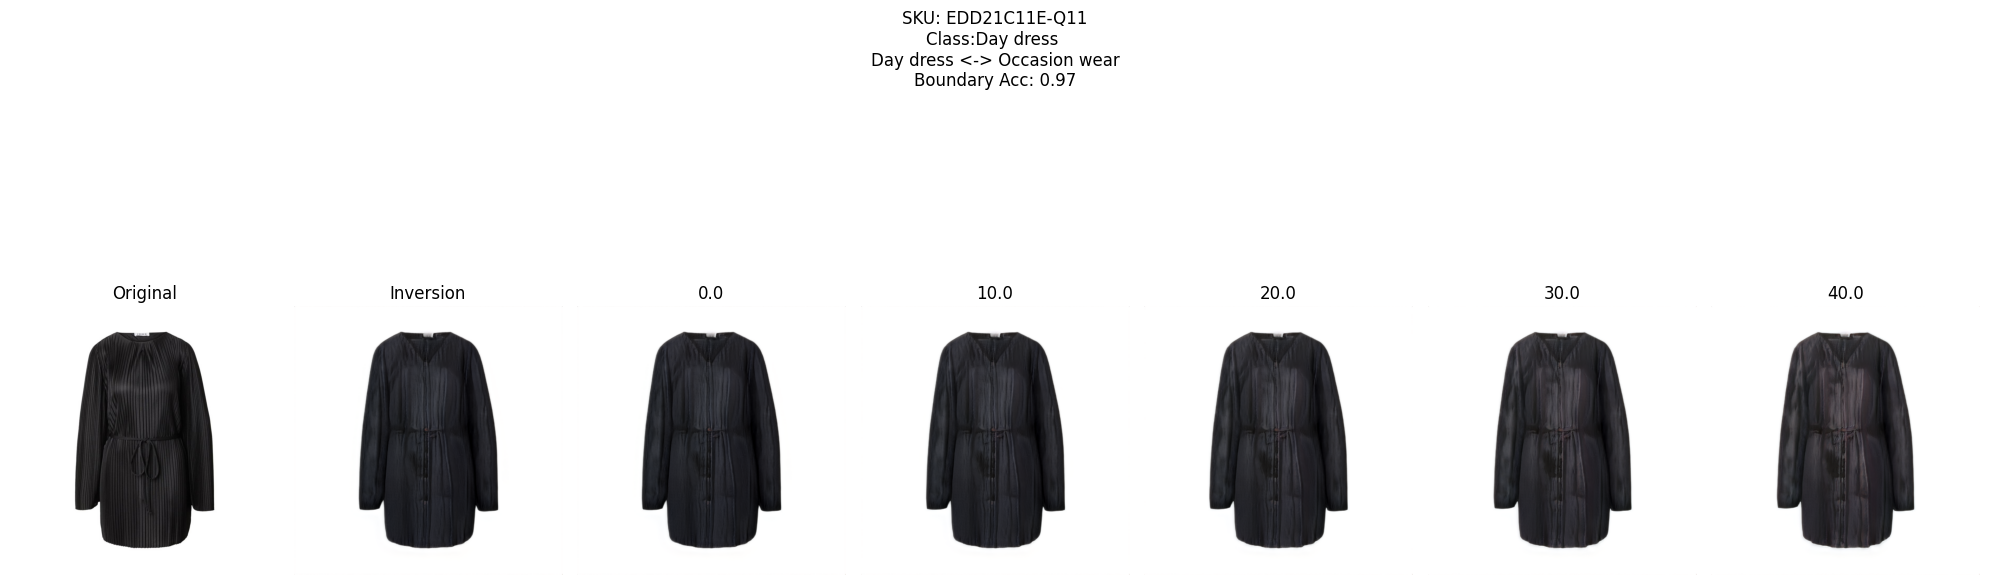

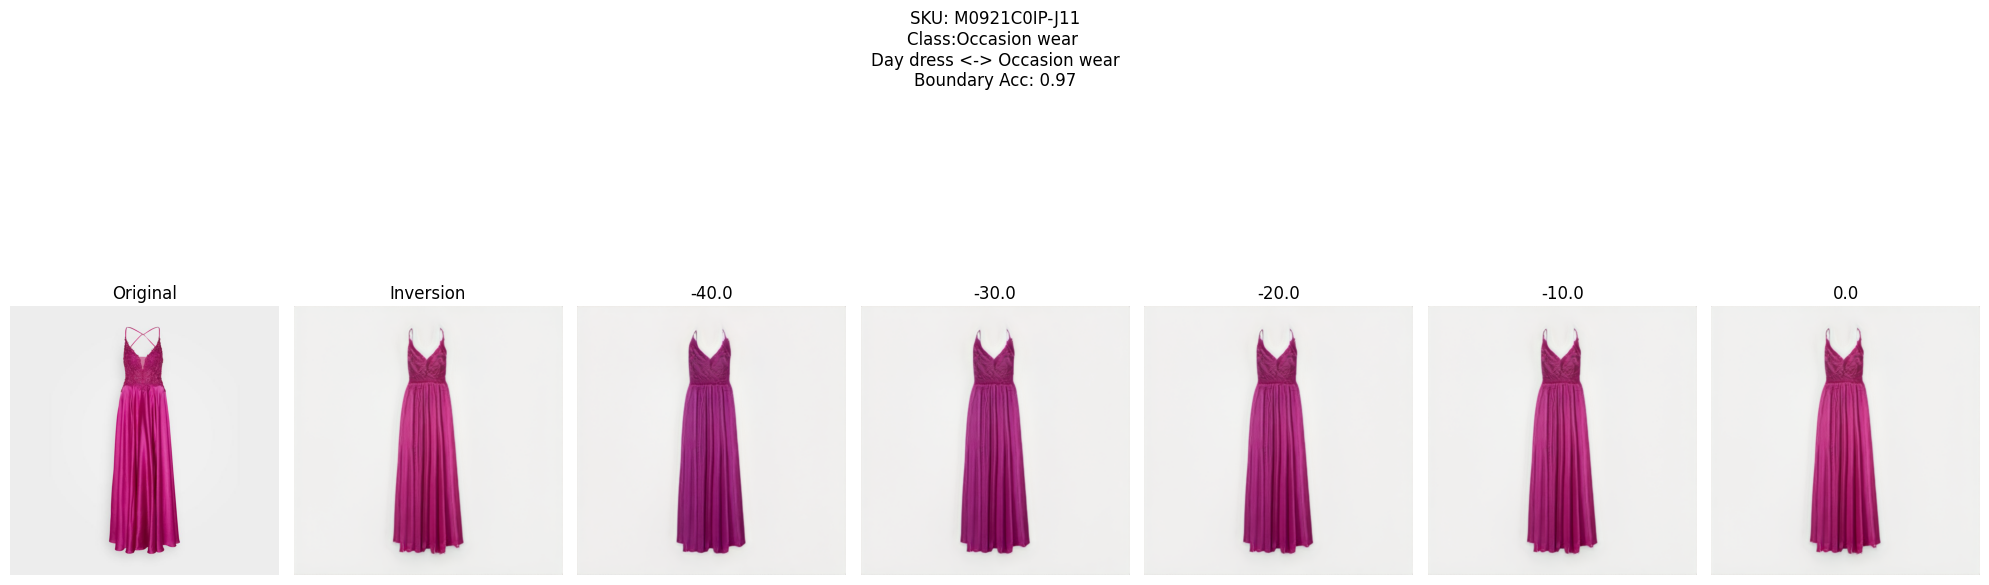

In [11]:
%matplotlib inline
attribute = 'category'
att1 = 'Day dress'
att2 = 'Occasion wear'
for _ in range(3):
    run_example(attribute, att1, att2)

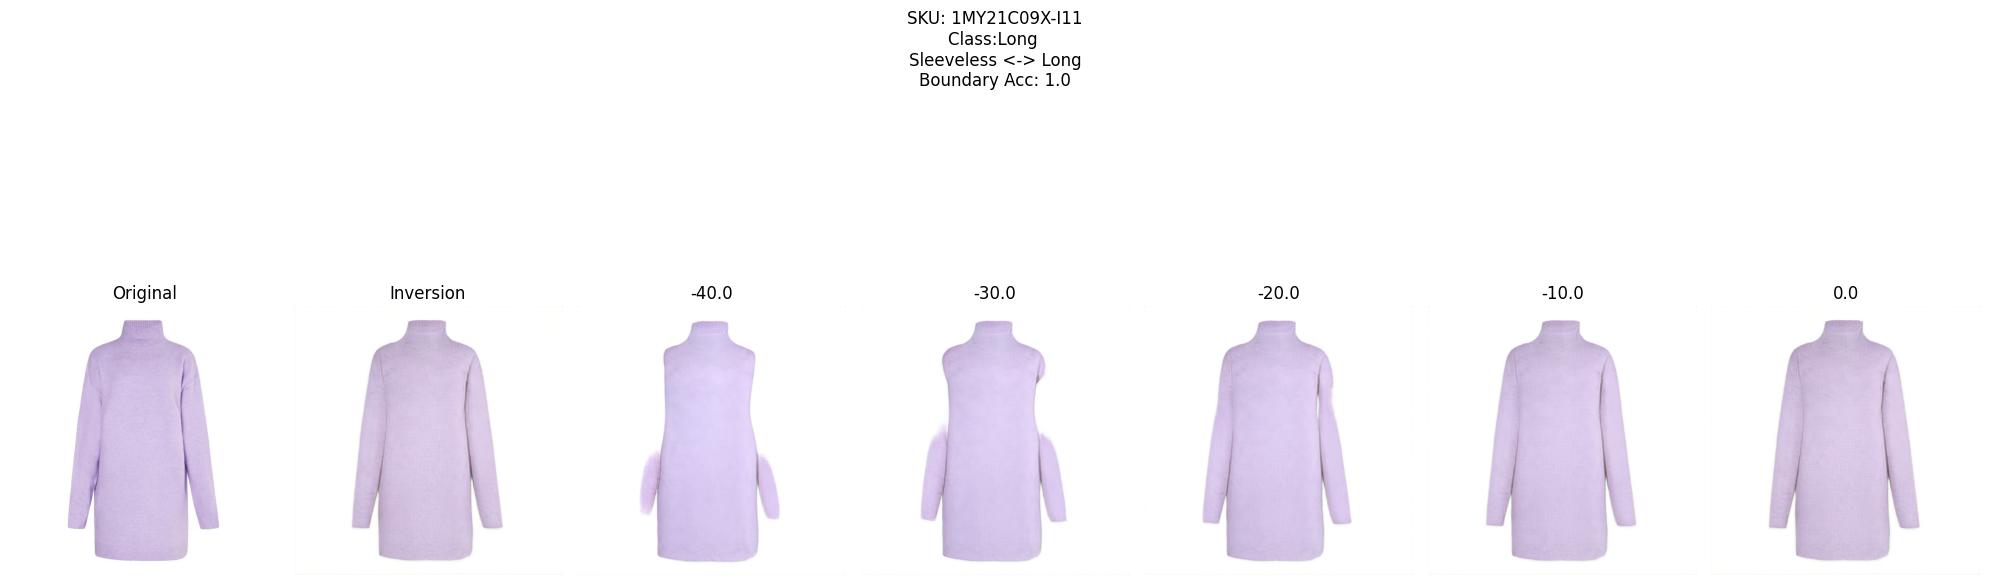

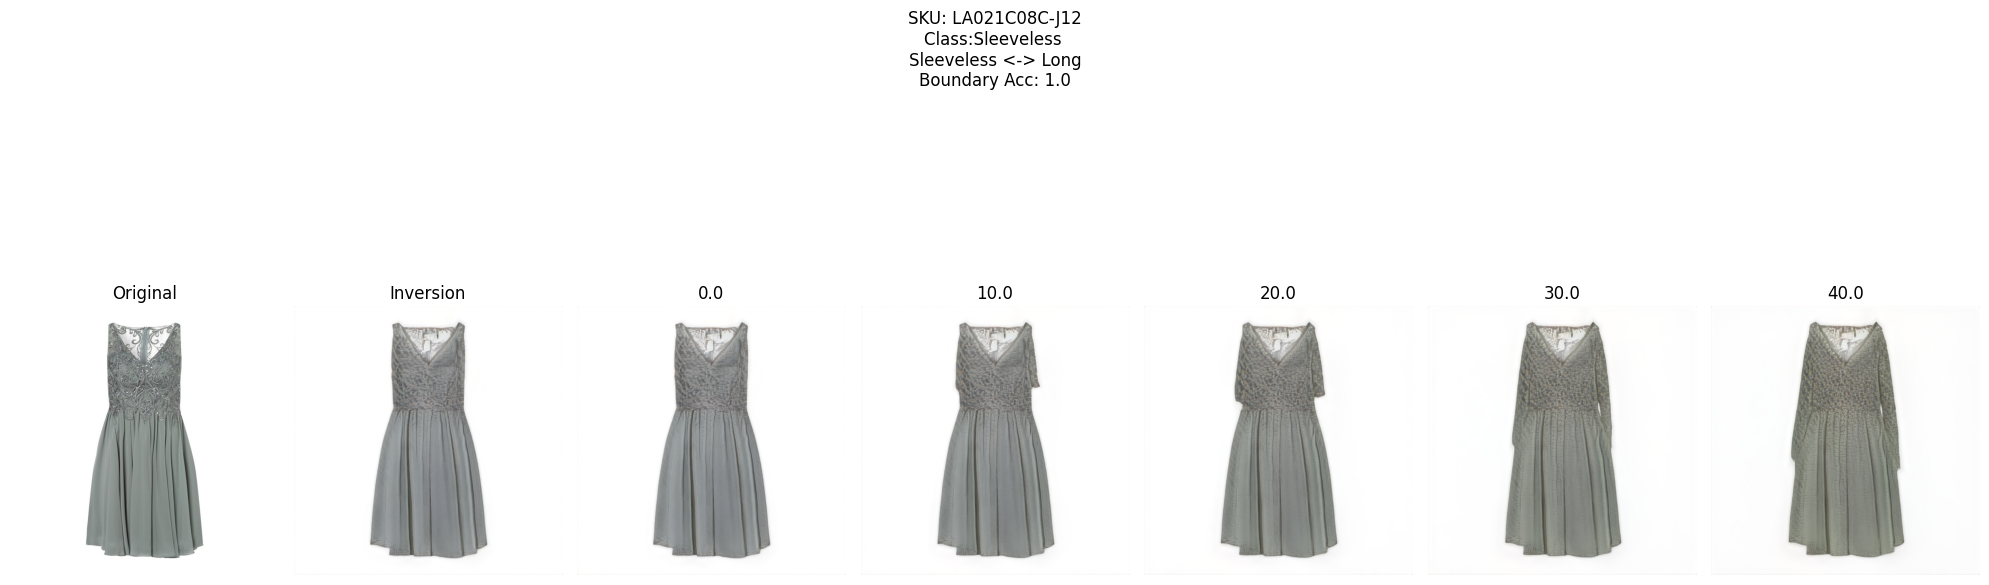

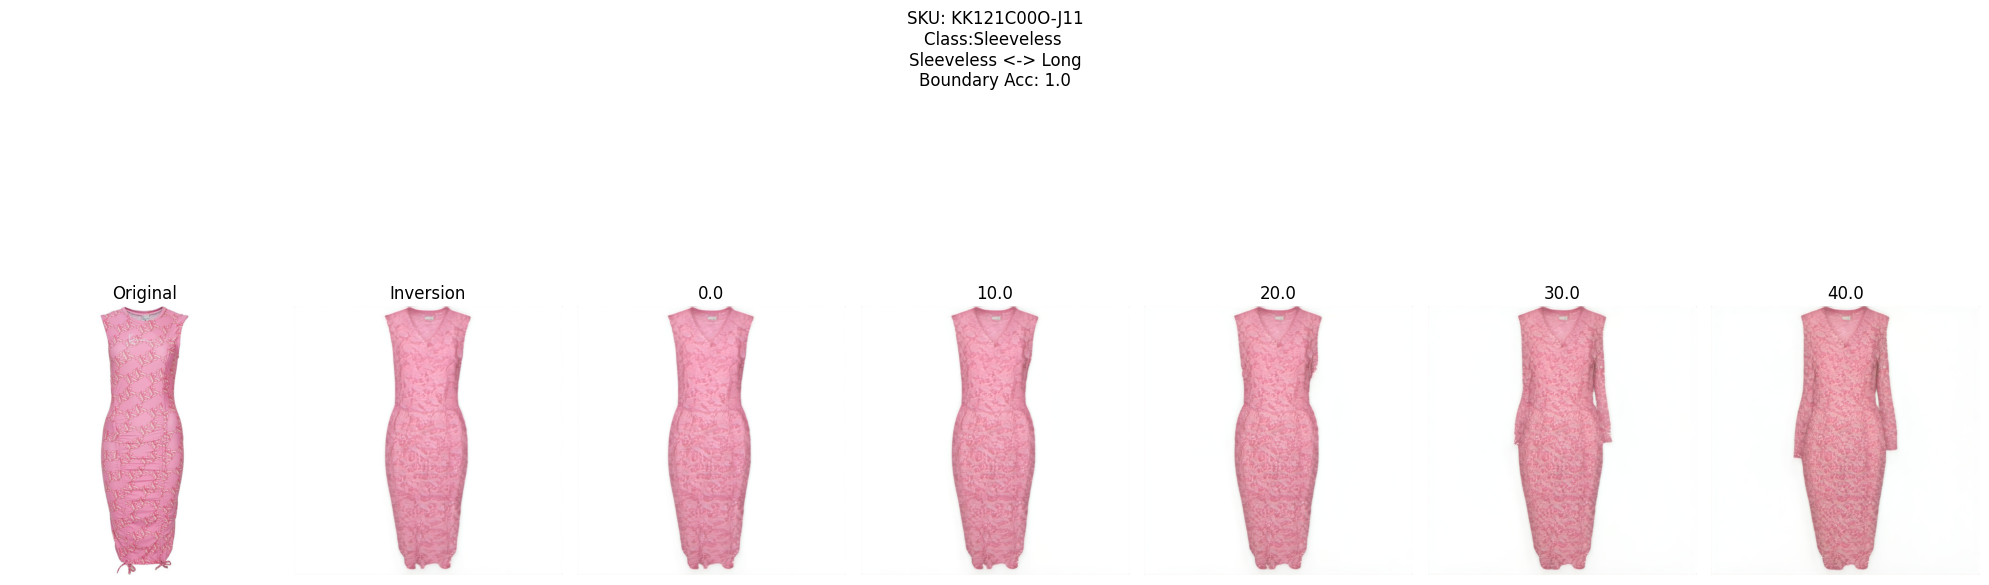

In [12]:
attribute = 'sleeve_length'
att1 = 'Long'
att2 = 'Sleeveless'
for _ in range(3):
    run_example(attribute, att1, att2)

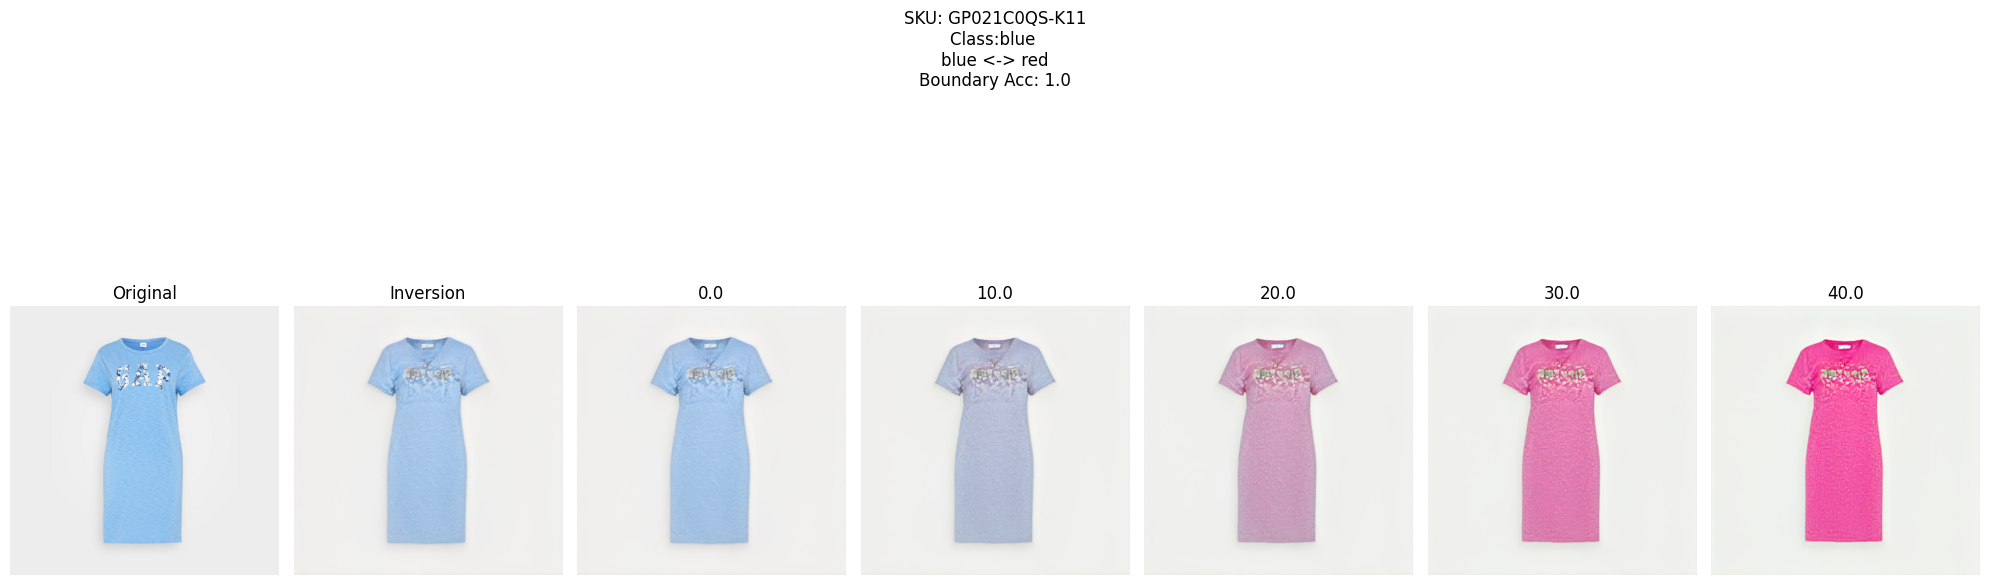

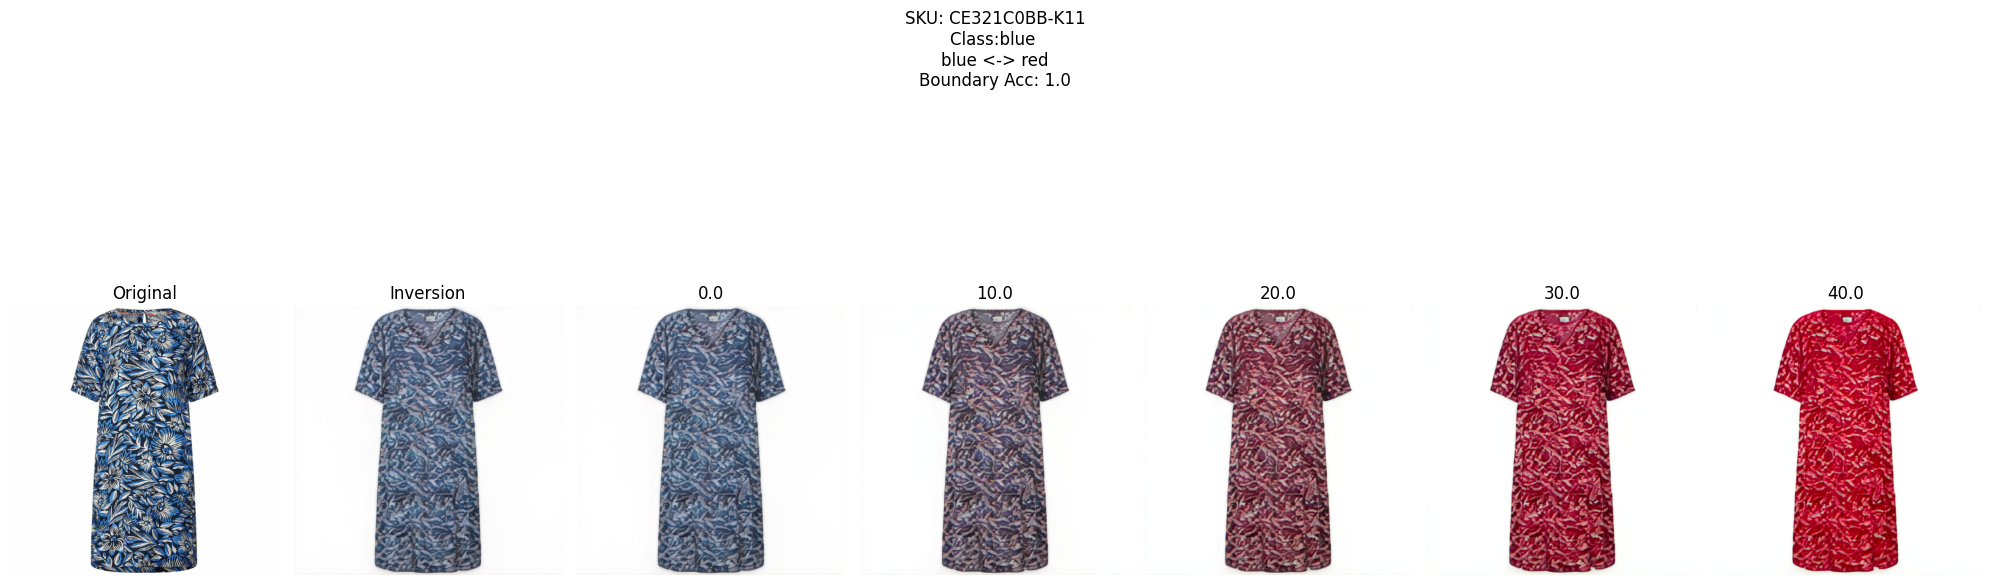

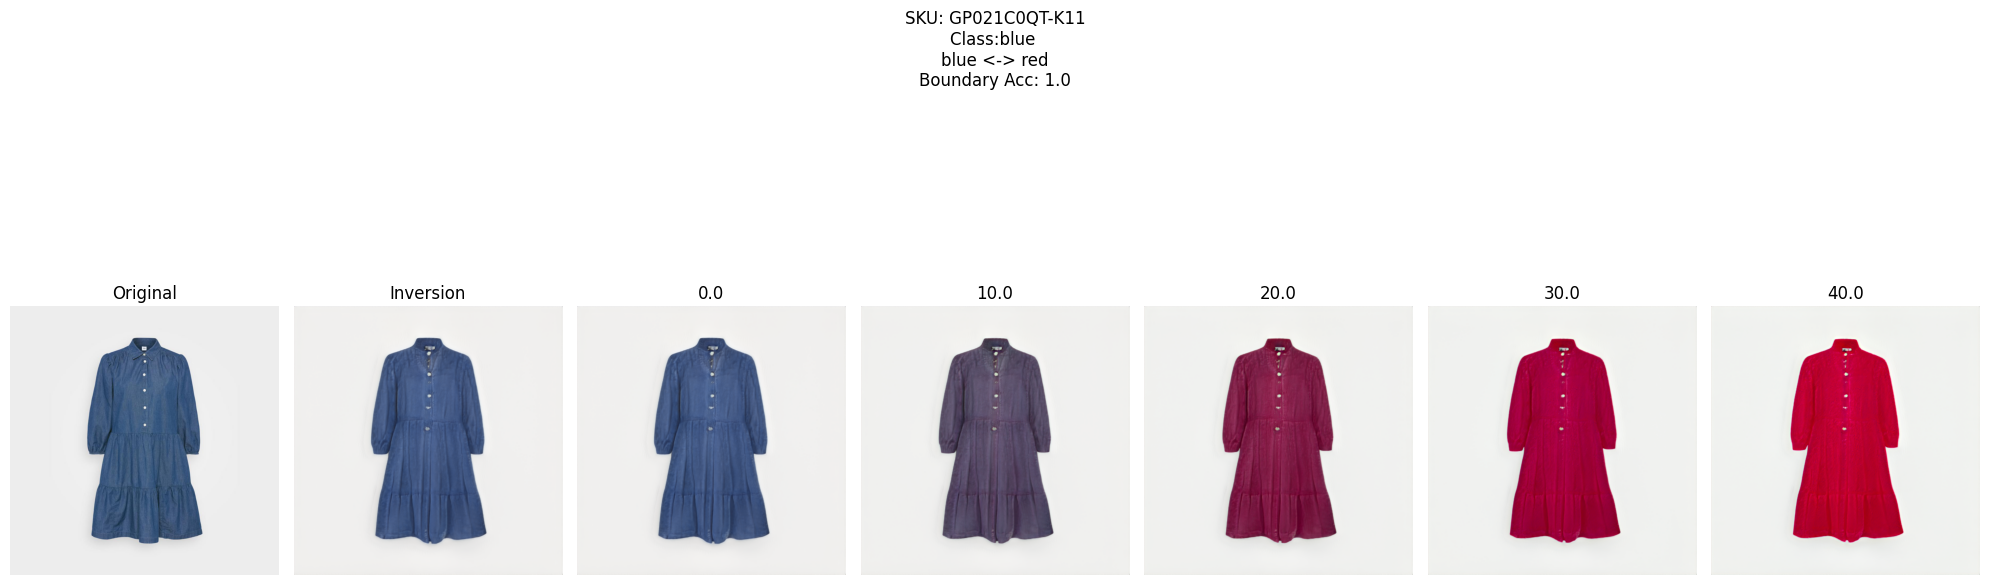

In [13]:
attribute = 'color'
att1 = 'red'
att2 = 'blue'
for _ in range(3):
    run_example(attribute, att1, att2)

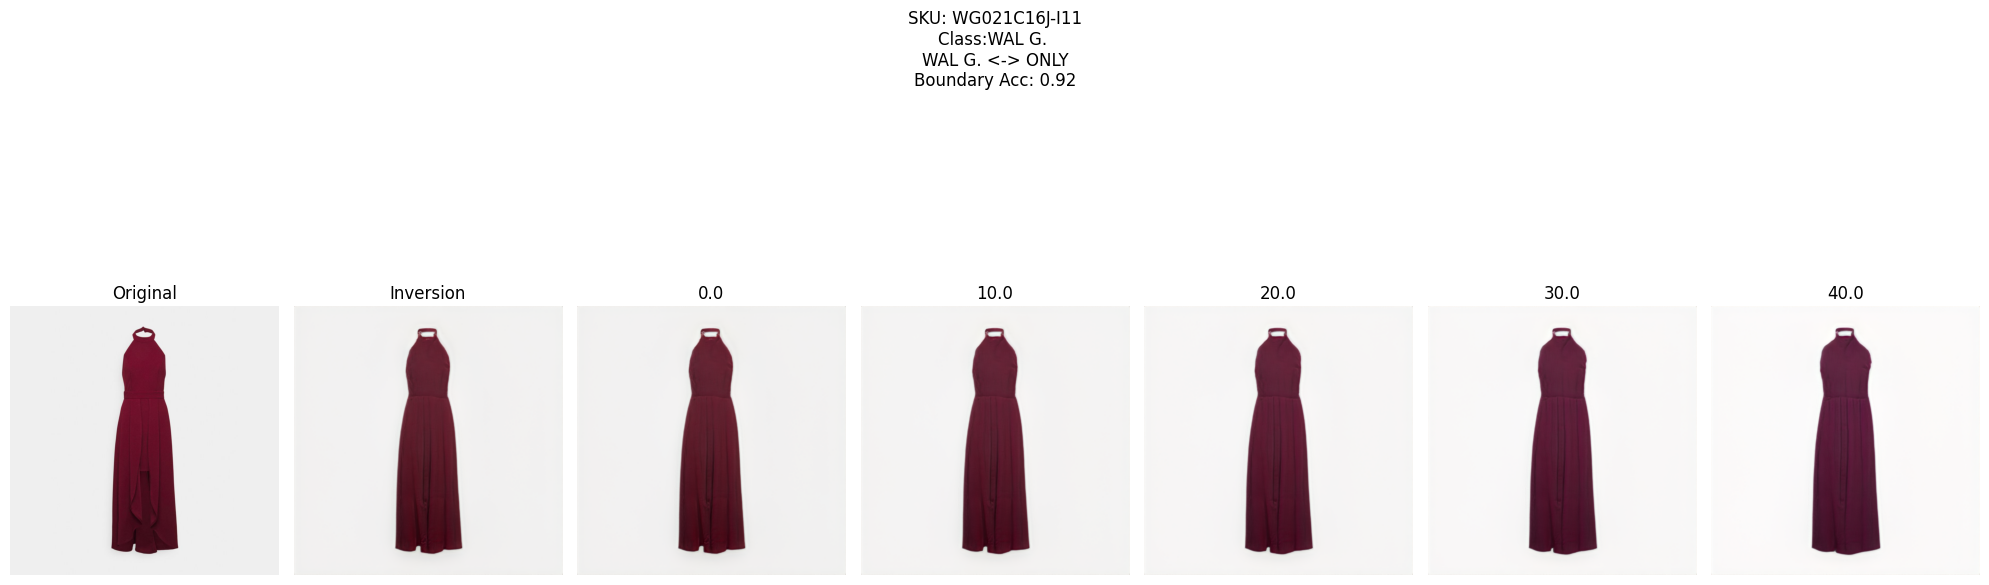

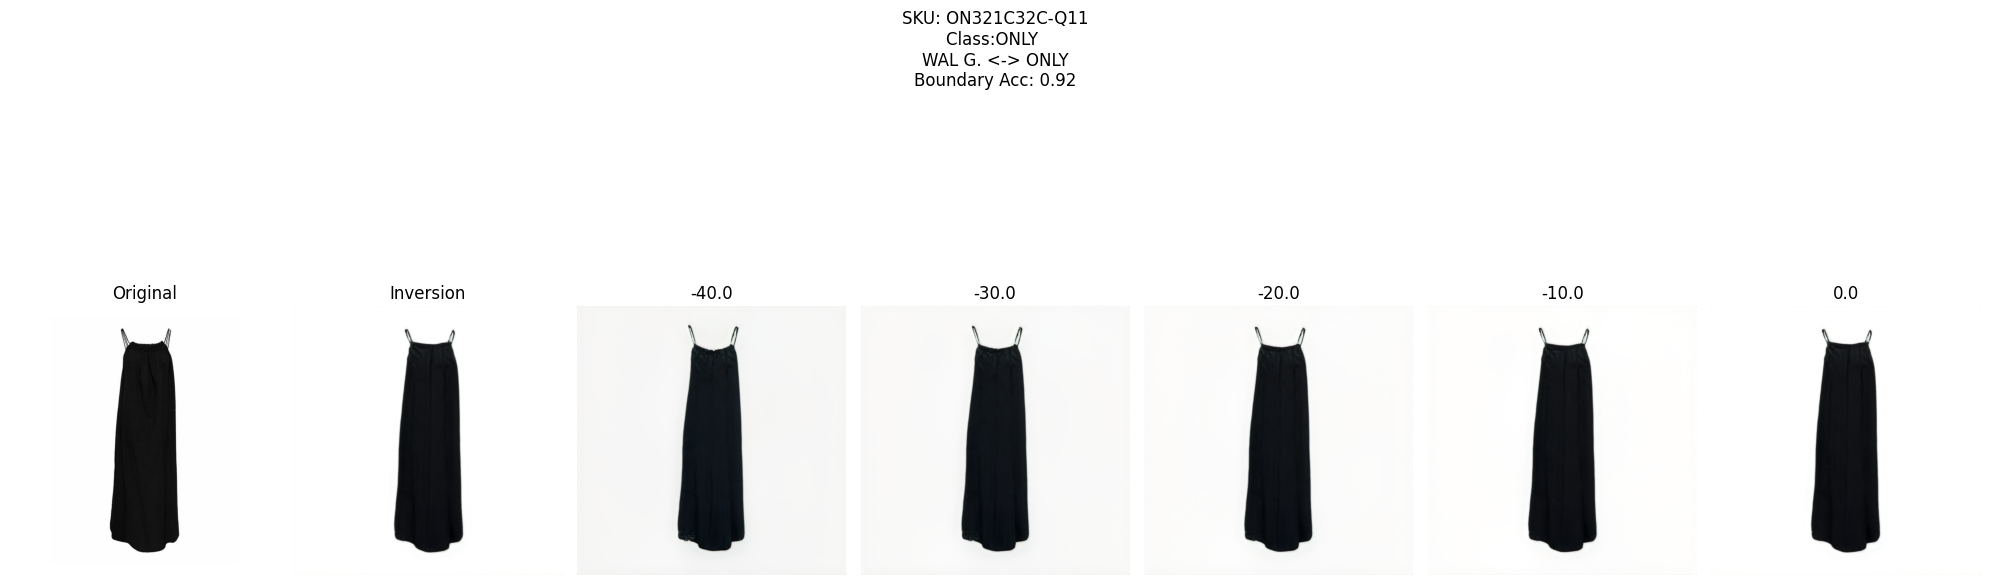

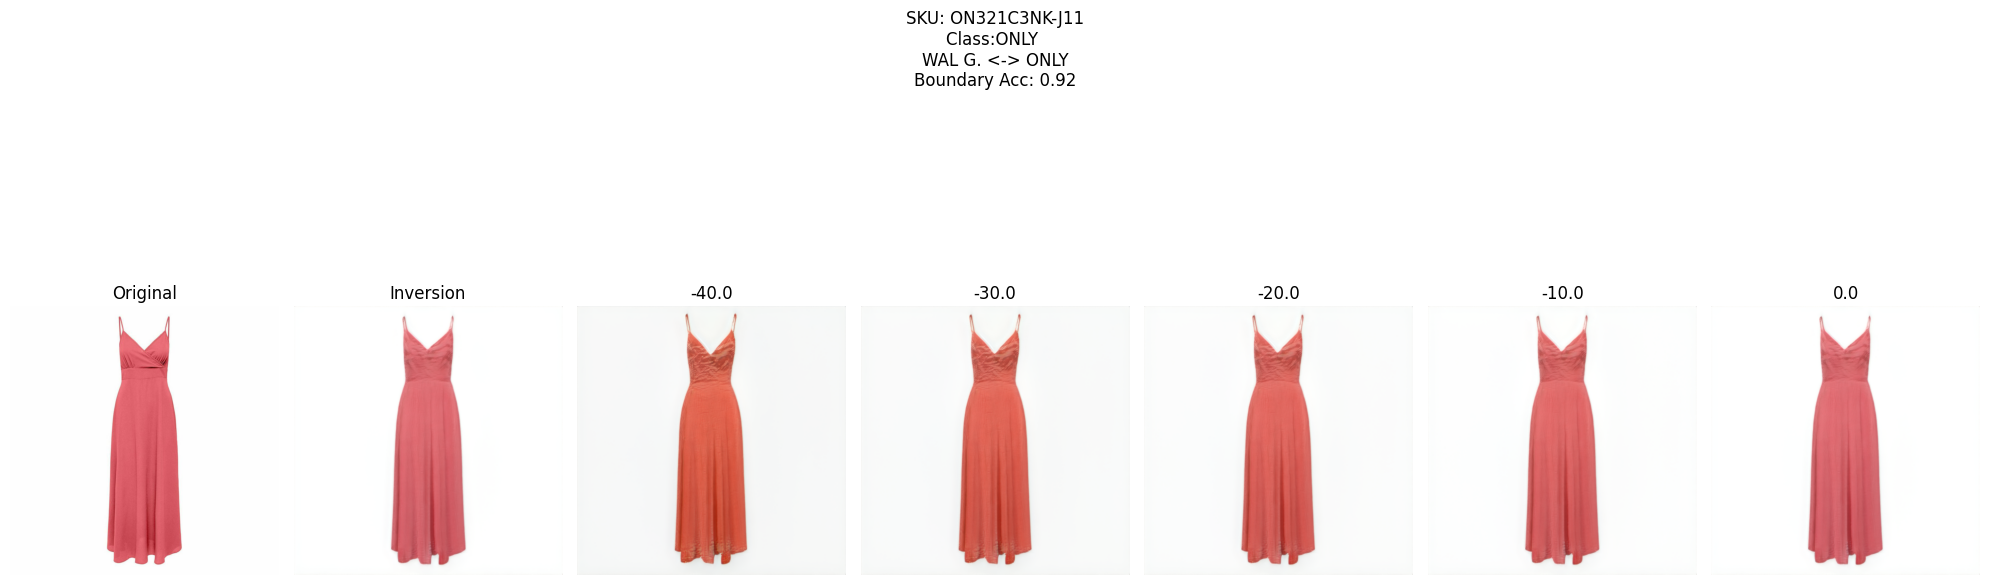

In [14]:
attribute = 'brand'
att1 = 'WAL G.'
att2 = 'ONLY'
for _ in range(3):
    run_example(attribute, att1, att2)